In [ ]:
"""
    Script that read the log file of the simulation and plot the data

    Since the log files are always called in the same way, the script can be run for every parameter, setting at the beginning
    a variable that describes the parameter considered.
    
    The data is the following:

    -   Scaling of the application with the number of worker: create a folder in which are saved the results of the simulation run 
        with different number of workers keeping unchanged the failure probability, the number of data and the number of operations.
        The "global" graph will have in the x-axis the number of workers and in the y-axis the time of the simulation.
        The "operation" graphs will have in the x-axis the number of workers and in the y-axis the time of the operations (one graph for each 
        operation: map, filter, changekey, reduce).

    -   Scaling of the application with the number of data: create a folder in which are saved the results of the simulation run with different
        number of data keeping unchanged the failure probability, the number of workers and the number of operations.
        The "global" graph will have in the x-axis the number of data and in the y-axis the time of the simulation.
        The "operation" graphs will have in the x-axis the number of data and in the y-axis the time of the operations (one graph for each
        operation: map, filter, changekey, reduce).

    -   Scaling of the application with the failure probability: create a folder in which are saved the results of the simulation run with different
        failure probability keeping unchanged the number of data, the number of workers and the number of operations.
        The "global" graph will have in the x-axis the failure probability and in the y-axis the time of the simulation.
        The "operation" graphs will have in the x-axis the failure probability and in the y-axis the time of the operations (one graph for each
        operation: map, filter, changekey, reduce).

    -   Scaling of the application with the batch size: create a folder in which are saved the results of the simulation run with different
        batch size keeping unchanged the number of data, the number of workers and the number of operations.
        The "global" graph will have in the x-axis the batch size and in the y-axis the time of the simulation.
        The "operation" graphs will have in the x-axis the batch size and in the y-axis the time of the operations (one graph for each
        operation: map, filter, changekey, reduce).
"""

In [2]:
import matplotlib.pyplot as plt
import os

In [3]:
parameter = "number_of_data"

number_of_workers = 0
number_of_data = 0
failure_probability = 0
batch_size = 0
schedule_size = 0

In [4]:
def read_log_to_vector(file_path):
    vector = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                number = float(line.strip())  # Convert string to float
                vector.append(number)
            except ValueError:
                print(f"Skipping non-numeric value: {line.strip()}")
    return vector

def read_logs_from_directory(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".log"):
            file_path = os.path.join(directory_path, filename)
            vector = read_log_to_vector(file_path)
            file_type = filename.split('_')[0]
            data.append((file_type, filename, vector))  
    return data

In [5]:
def creating_worker_data(directory_path):
    global number_of_workers
    global number_of_data
    global failure_probability
    global batch_size
    global schedule_size

    sim_data = []
    wrk_data = []

    all_data = read_logs_from_directory(directory_path)

    for idx, (file_type, filename, vector) in enumerate(all_data, start=1):
        if file_type == "SIM":
            sim_data.append((filename, vector))
        elif file_type == "WRK":
            wrk_data.append((filename, vector))
            
    sim_parts = sim_data[0][0].split('_')
    number_of_workers = int(sim_parts[1])
    failure_probability = float(sim_parts[2])
    number_of_data = int(sim_parts[3])
    batch_size = int(sim_parts[4])
    schedule_size = int(sim_parts[5].split('.')[0])
    
    if parameter == "number_of_workers":
        par = int(number_of_workers)
    elif parameter == "number_of_data":
        par = number_of_data
    elif parameter == "failure_probability":
        par = failure_probability
    elif parameter == "batch_size":
        par = batch_size
    elif parameter == "schedule_size":
        par = schedule_size

    map_results = []
    filter_results = []
    changekey_results = []
    reduce_results = []
    exec_time = []


    for id, (filename, vector) in enumerate(wrk_data, start=1):
        wrk_parts = filename.split('_')
        if wrk_parts[2] == "map":
            map_results.append(sum(vector))
        elif wrk_parts[2] == "filter":
            filter_results.append(sum(vector))
        elif wrk_parts[2] == "changekey":
            changekey_results.append(sum(vector))
        elif wrk_parts[2] == "execTime":
            exec_time.append(sum(vector))
        elif wrk_parts[2] == "reduce":
            reduce_results.append(sum(vector))

    operation_dataset = [[] for _ in range(number_of_workers)]
    
    for idx in range(number_of_workers):
        wrk_istance = ((idx, par, map_results[idx], filter_results[idx], changekey_results[idx], reduce_results[idx]))
        operation_dataset[idx].append(wrk_istance)

    return operation_dataset
 
    

In [6]:
wrk_dataset = []

def iterate_subdirectories(directory_path):
    global wrk_dataset 
    wrk_dataset = []
    first_iteration = True

    for subdirectory in os.listdir(directory_path):
        subdirectory_path = os.path.join(directory_path, subdirectory)
        
        if os.path.isdir(subdirectory_path):
            appo = creating_worker_data(subdirectory_path)
            if first_iteration:
                wrk_dataset = appo
                first_iteration = False
            else:
                current_number_of_workers = len(wrk_dataset)
                if number_of_workers > current_number_of_workers:
                    wrk_dataset.extend([[] for _ in range(number_of_workers - current_number_of_workers)])
                for idx in range(number_of_workers):
                    wrk_dataset[idx].extend(appo[idx])


In [7]:

def plotter(parameter_vector, map_vector, filter_vector, changekey_vector, reduce_vector):
    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))

    # List of labels for each operation
    operations = ['Map', 'Filter', 'ChangeKey', 'Reduce']

    # Plot each operation
    for i, operation in enumerate(operations):
        # Plot data for each worker
        for j in range(number_of_workers):
            if operation == 'Map':
                if parameter == "number_of_workers":
                    axs[i].plot(parameter_vector[j], map_vector[j])
                else:
                    axs[i].plot(parameter_vector[j], map_vector[j], label=f"Worker {j}")
            elif operation == 'Filter':
                if parameter == "number_of_workers":
                    axs[i].plot(parameter_vector[j], filter_vector[j])
                else:
                    axs[i].plot(parameter_vector[j], filter_vector[j], label=f"Worker {j}")
            elif operation == 'ChangeKey':
                if parameter == "number_of_workers":
                    axs[i].plot(parameter_vector[j], changekey_vector[j])
                else:
                    axs[i].plot(parameter_vector[j], changekey_vector[j], label=f"Worker {j}")
            elif operation == 'Reduce':
                if parameter == "number_of_workers":
                    axs[i].plot(parameter_vector[j], reduce_vector[j])
                else:
                    axs[i].plot(parameter_vector[j], reduce_vector[j], label=f"Worker {j}")
        
        # Set titles and labels
        axs[i].set_title(f"{operation} Operation")
        axs[i].set_xlabel(parameter)
        axs[i].set_ylabel(f"{operation} Time")
        axs[i].legend()

    plt.tight_layout()
    plt.show()


In [8]:
def splitting_logs():
    parameter_vector = [[] for _ in range(number_of_workers)]
    map_vector = [[] for _ in range(number_of_workers)]
    filter_vector = [[] for _ in range(number_of_workers)]
    changekey_vector = [[] for _ in range(number_of_workers)]
    reduce_vector = [[] for _ in range(number_of_workers)]

    for idx, wrk in enumerate(wrk_dataset):
        for log in wrk:
            parameter_vector[idx].append(log[1])
            map_vector[idx].append(log[2])
            filter_vector[idx].append(log[3])
            changekey_vector[idx].append(log[4])
            reduce_vector[idx].append(log[5])
    
    plotter(parameter_vector, map_vector, filter_vector, changekey_vector, reduce_vector)
    

## INCREASING NUMBER OF DATA 

- The data size is increased at every simulation of 500 + (0:10) values 
- The number of workers is fixed at 4 
- The failure probability is fixed at 0.1
- The batch size is fixed at 8

Considerations: As expected the worakload of each worker increases with the data quantity

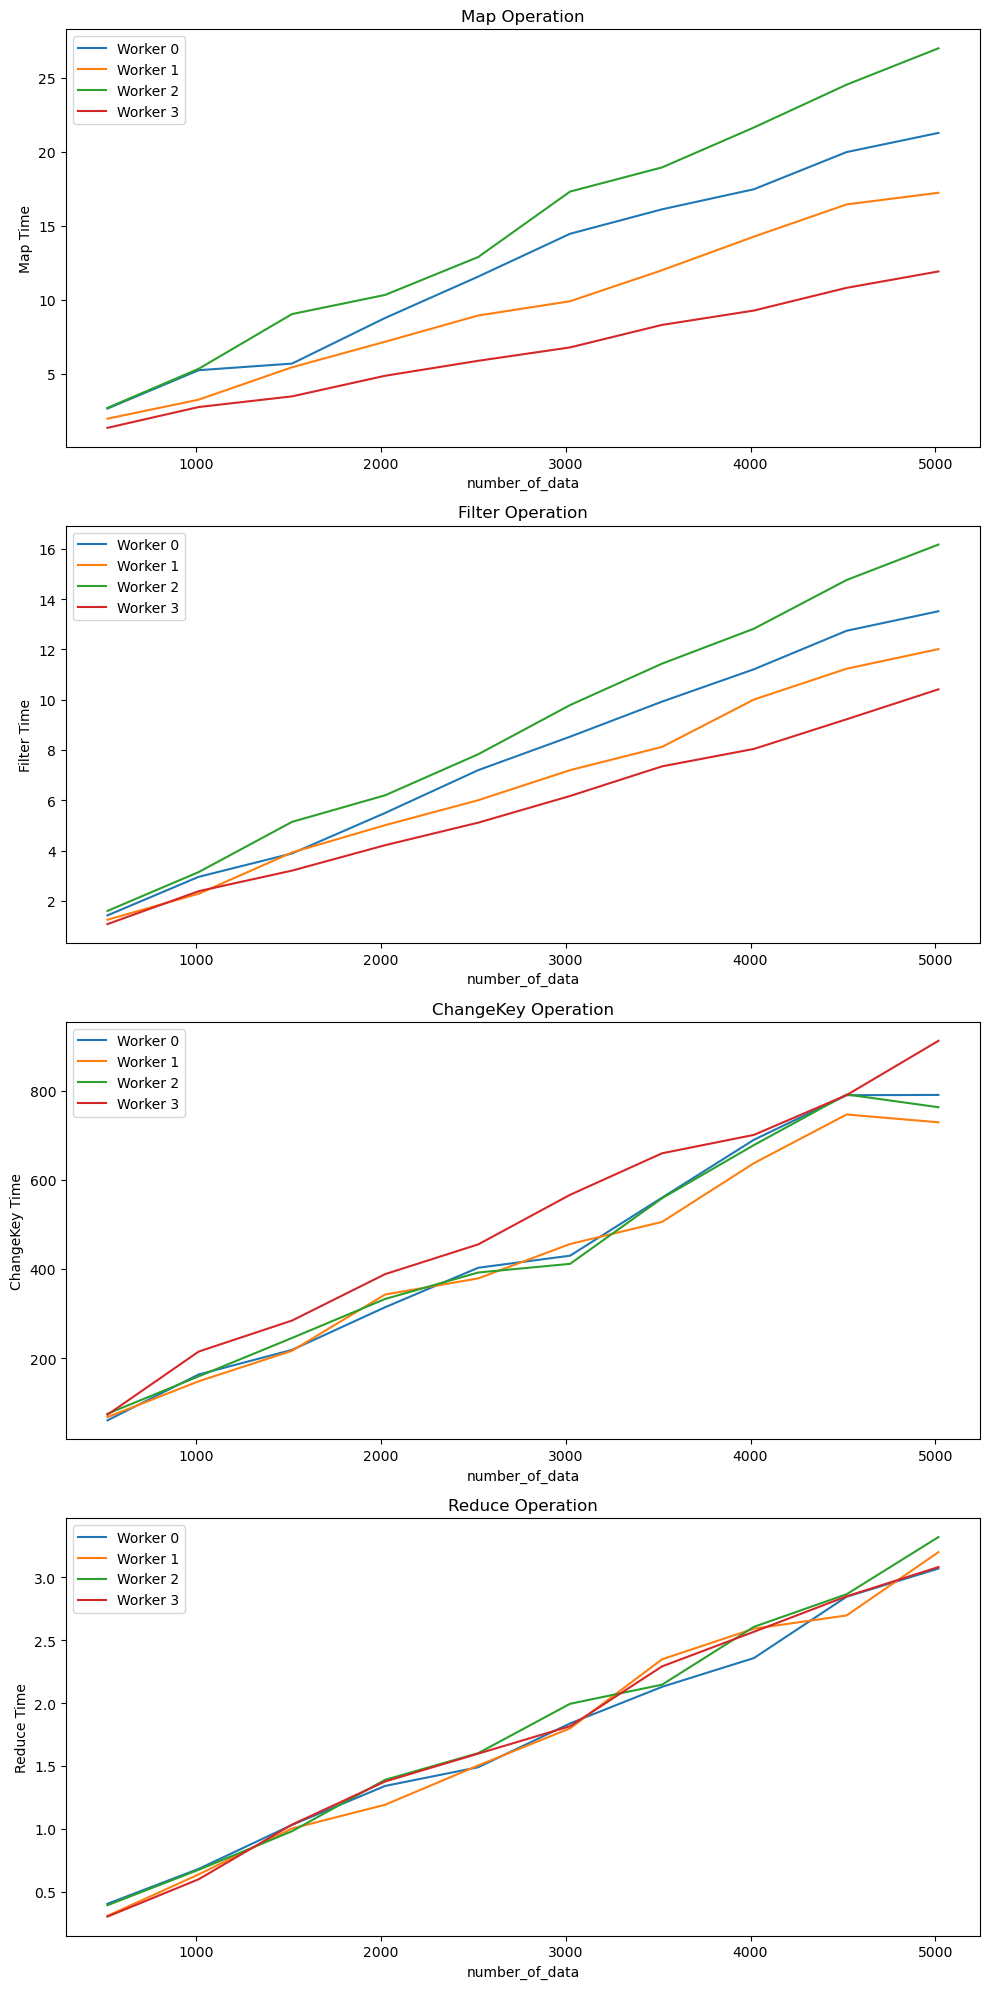

In [9]:
parameter = "number_of_data"
iterate_subdirectories("Logs/Increasing_Number_of_Data")
splitting_logs()

# INCREASING NUMBER OF WORKERS

- The number of workers is increased at each simulation, in particular have been used 1, 2, 3, 4, 5, 6, 8, 10, 15, 30 workers
- The quantity of data is always 5000 + (0:50), is then divided among all the workers available in each simulation
- The failure probability is fixed at 0.1
- The batch size is fixed at 8

Conisderations: Every line in the graph represents the workload of each worker, the lines begin in the middle of the graphs and not at the beginning because whenever a new simulation is performed new workers are added and so the plotting regarding them starts from that point.
It can be seen that Each time new workers are added, the workload for each individual decreases, and the more workers are added, the less total workload there will be for each of them.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


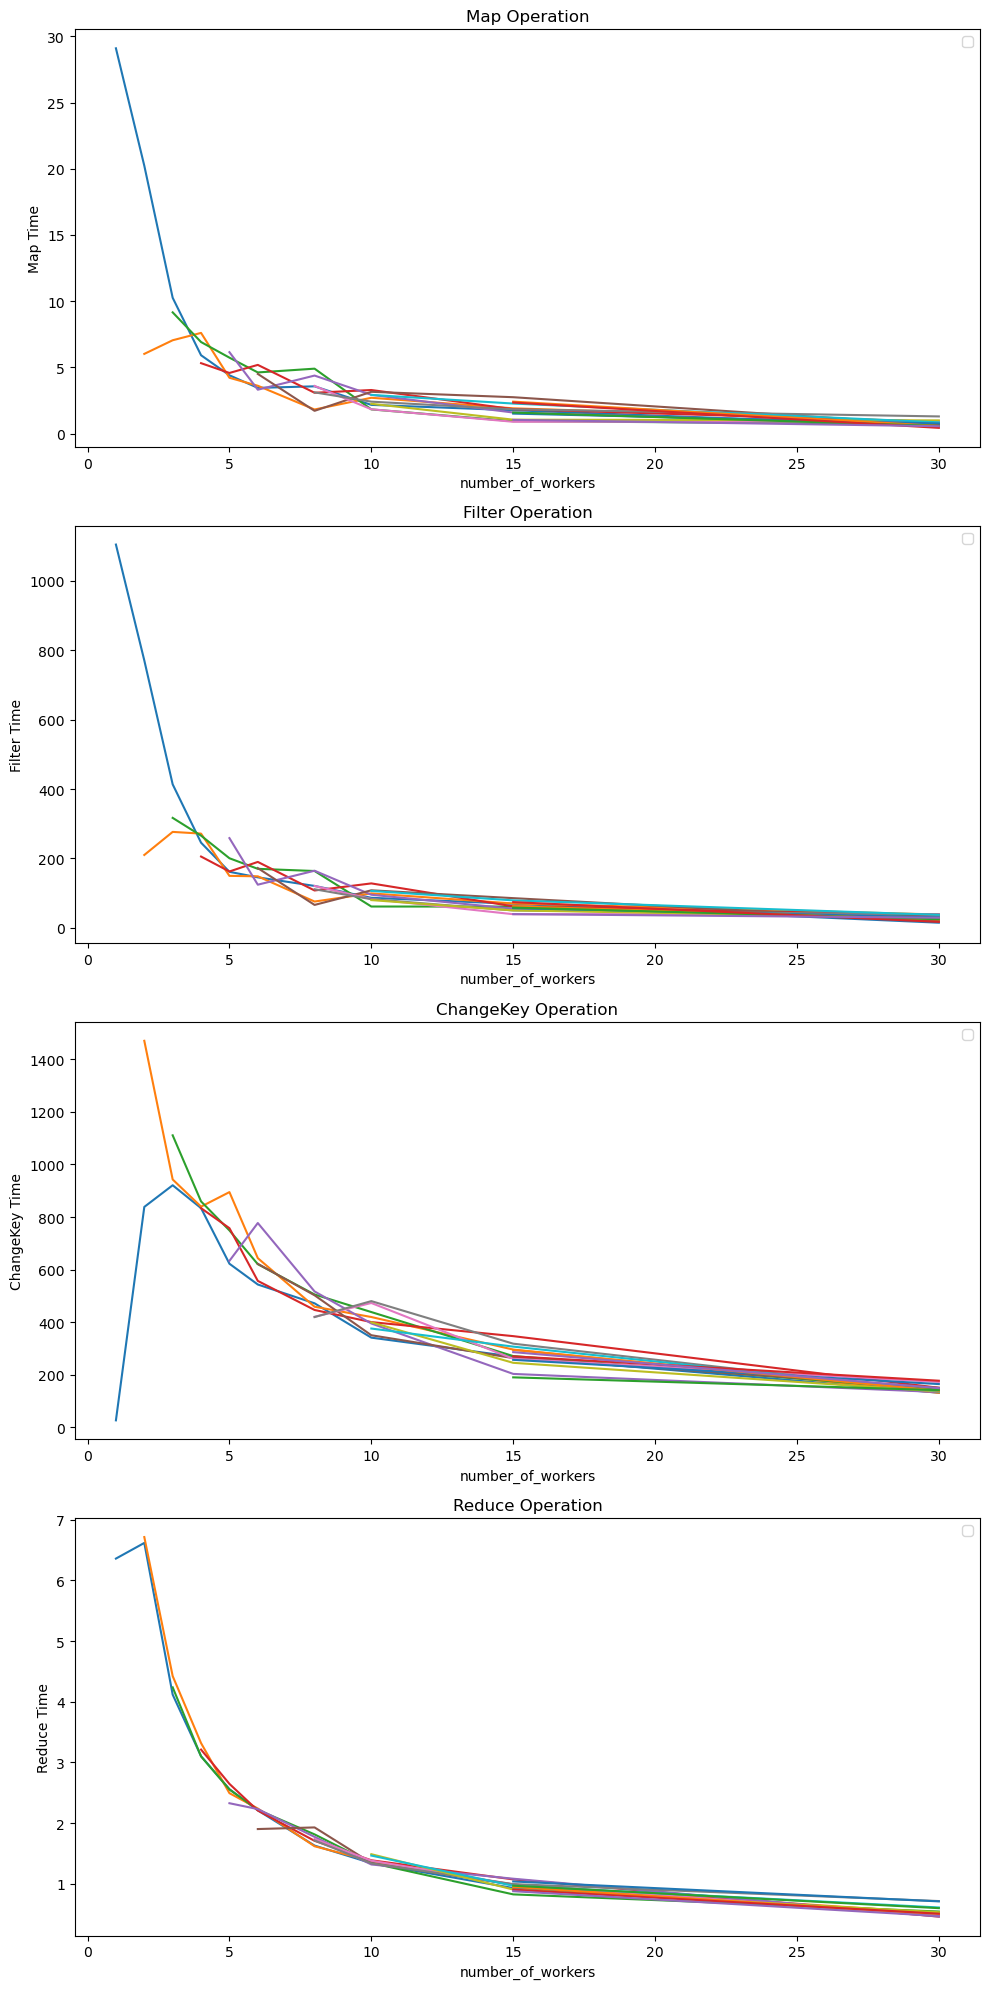

In [81]:
parameter = "number_of_workers"
iterate_subdirectories("Logs/Increasing_Number_of_Workers")
splitting_logs()

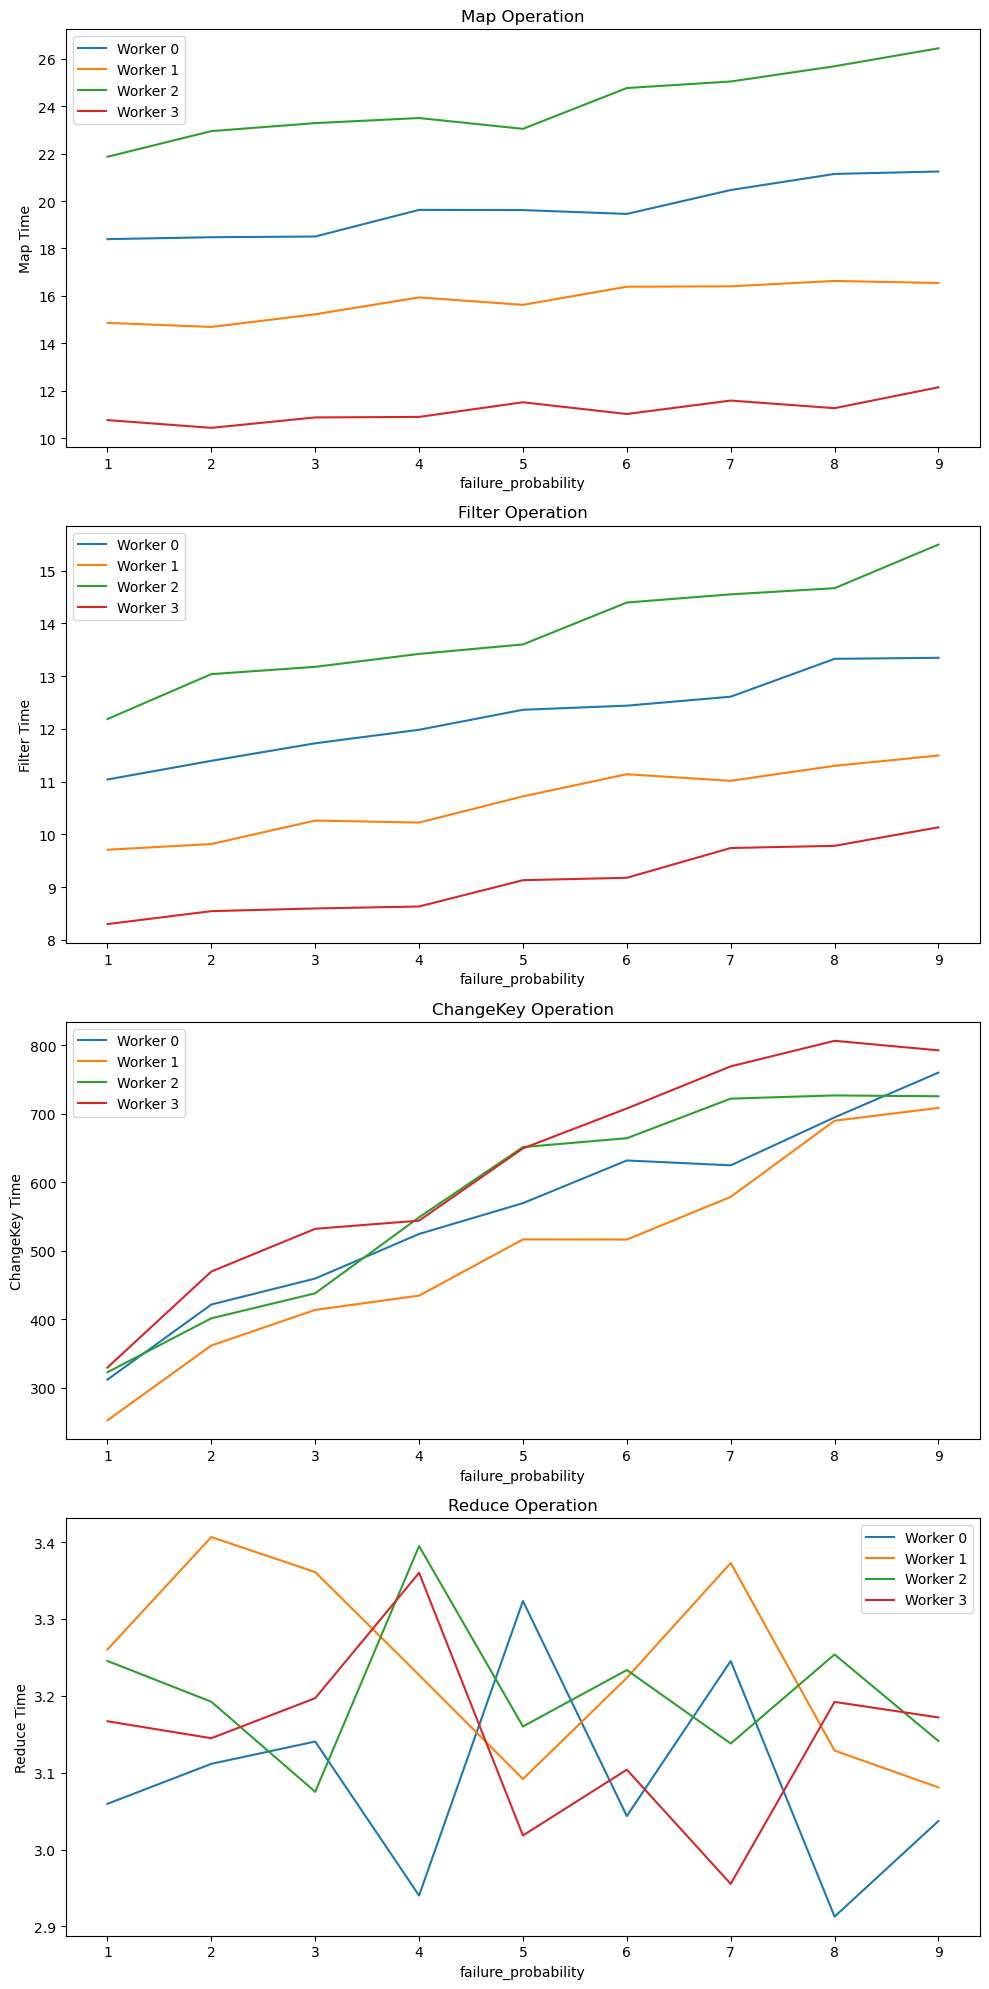

In [13]:
parameter = "failure_probability"
iterate_subdirectories("Logs/Increasing_Failure_Probability")
splitting_logs()